In [1]:
!pip install bs4
#!pip install requestssoup = BeautifulSoup(data,"html5lib")
from bs4 import BeautifulSoup # this module helps in web scrapping.
import re
import requests  # this module helps us to download a web page
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 122kB 12.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 112kB 12.9MB/s eta 0:00:01
Libraries imported.


In [2]:
#The below url contains html tables with neighborhood zip code for San Francisco
url = "http://www.healthysf.org/bdi/outcomes/zipmap.htm"
data  = requests.get(url).text

In [3]:
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data'
tables = soup.find_all('table')
zip_neighborhood = pd.DataFrame(columns=["ZipCode", "Neighborhood"])

for row in tables[2].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        zipcode = col[0].get_text().replace('\n',' ')
        neighborhood = col[1].get_text().replace('\n',' ')
        zip_neighborhood = zip_neighborhood.append({"ZipCode":zipcode, "Neighborhood":neighborhood}, ignore_index=True)

zip_neighborhood['ZipCode'] = zip_neighborhood['ZipCode'].astype(str)
zip_neighborhood.drop_duplicates(subset=['ZipCode'],inplace=True)
zip_neighborhood = zip_neighborhood[~zip_neighborhood.ZipCode.str.contains('|'.join(['Zip']))].reset_index(drop=True)
zip_neighborhood

,ZipCode,Neighborhood
0,94102,Hayes Valley/Tenderloin/North ...
1,94103,South of Market
2,94107,Potrero Hill
3,94108,Chinatown
4,94109,Polk/Russian Hill (Nob Hill)
5,94110,Inner Mission/Bernal Heights
6,94112,Ingelside-Excelsior/Crocker-Amazon
7,94114,Castro/Noe Valley
8,94115,Western Addition/Japantown
9,94116,Parkside/Forest Hill


In [4]:
zip_location = pd.read_csv("sanfrancisco-zip-code-latitude-and-longitude.csv", sep=";", usecols=[0,3,4], names=["ZipCode", "Latitude", "Longitude"],header=0)
zip_location['ZipCode'] = zip_location['ZipCode'].astype(str)
zip_location.head()

,ZipCode,Latitude,Longitude
0,94146,37.784827,-122.727802
1,94165,37.784827,-122.727802
2,94155,37.784827,-122.727802
3,94138,37.784827,-122.727802
4,94169,37.784827,-122.727802


In [6]:
sf_data = zip_neighborhood.merge(zip_location, on='ZipCode')
sf_data

,ZipCode,Neighborhood,Latitude,Longitude
0,94102,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915
1,94103,South of Market,37.772329,-122.41087
2,94107,Potrero Hill,37.766529,-122.39577
3,94108,Chinatown,37.792678,-122.40793
4,94109,Polk/Russian Hill (Nob Hill),37.792778,-122.42188
5,94110,Inner Mission/Bernal Heights,37.748730,-122.41545
6,94112,Ingelside-Excelsior/Crocker-Amazon,37.720931,-122.44241
7,94114,Castro/Noe Valley,37.758434,-122.43512
8,94115,Western Addition/Japantown,37.786129,-122.43736
9,94116,Parkside/Forest Hill,37.743381,-122.48578


In [7]:
#The below url contains html tables with data about world population.
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [8]:
# get the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text

In [9]:
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data'

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [10]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [11]:
df_postcode = df.assign(Neighborhood=df.Neighborhood.str.split(",")).explode('Neighborhood')

df_postcode.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Manor


In [12]:
url ='https://cocl.us/Geospatial_data'
locgeo_df  = pd.read_csv(url,index_col='Postal Code')
locgeo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [13]:
toronto_data = df_postcode.join(locgeo_df, on='PostalCode')
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [14]:
#Filter only Toronto boroughs
toronto_downtown_data = toronto_data.set_index('Borough').filter(like='Downtown Toronto', axis=0).reset_index(drop=True)
toronto_downtown_data.head()

,PostalCode,Neighborhood,Latitude,Longitude
0,M5A,Regent Park,43.654260,-79.360636
1,M5A,Harbourfront,43.654260,-79.360636
2,M5B,Garden District,43.657162,-79.378937
3,M5B,Ryerson,43.657162,-79.378937
4,M5C,St. James Town,43.651494,-79.375418


In [15]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [16]:
CLIENT_ID = '51Z3VVSTTJIGOGV2ZKED3KDNM0Z2D2XSAJDX5G2VPTYNU2YB' # your Foursquare ID
CLIENT_SECRET = 'EK3IM425BPCKE4NR3IYDKFWQA2JWHNSKSTT0MQKV5GKAK11I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [17]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
results = requests.get(url).json()['response']['categories']

results_normalized1 = pd.json_normalize(results, record_path=['categories'],meta=['name'], meta_prefix='meta-')
results_normalized2 = pd.json_normalize(results, record_path=['categories','categories'],meta=['name'], meta_prefix='meta-')
results_normalized3 =  pd.json_normalize(results, record_path=['categories','categories','categories'],meta=['name'], meta_prefix='meta-')
results_normalized = pd.DataFrame().append([results_normalized1,results_normalized2,results_normalized3])
categories = results_normalized[['name','meta-name']].rename(columns={'name': "Category",'meta-name': 'CategoryGroup'})
categories.sort_values(by=['CategoryGroup','Category'],inplace=True)
categories.head()

,Category,CategoryGroup
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
3,Art Museum,Arts & Entertainment


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_downtown_venues = getNearbyVenues(names=toronto_downtown_data['Neighborhood'],
                                   latitudes=toronto_downtown_data['Latitude'],
                                   longitudes=toronto_downtown_data['Longitude']
                                  )

Regent Park
 Harbourfront
Garden District
 Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond
 Adelaide
 King
Harbourfront East
 Union Station
 Toronto Islands
Toronto Dominion Centre
 Design Exchange
Commerce Court
 Victoria Hotel
University of Toronto
 Harbord
Kensington Market
 Chinatown
 Grange Park
CN Tower
 King and Spadina
 Railway Lands
 Harbourfront West
 Bathurst Quay
 South Niagara
 Island airport
Rosedale
Enclave of M5E
St. James Town
 Cabbagetown
First Canadian Place
 Underground city
Church and Wellesley


In [20]:
toronto_downtown_venues.insert(0, 'City', 'Toronto')

toronto_downtown_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Toronto,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Toronto,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Toronto,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Toronto,Regent Park,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [21]:
sf_venues = getNearbyVenues(names=sf_data['Neighborhood'],
                                   latitudes=sf_data['Latitude'],
                                   longitudes=sf_data['Longitude']
                                  )

Hayes                 Valley/Tenderloin/North of Market
South                 of Market
Potrero                 Hill
Chinatown                 
Polk/Russian                 Hill (Nob Hill)
Inner                 Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe                 Valley 
Western                 Addition/Japantown
Parkside/Forest                 Hill 
Haight-Ashbury
Inner                 Richmond 
Outer                 Richmond 
Sunset
Marina
Bayview-Hunters                 Point 
St.                 Francis Wood/Miraloma/West Portal
Twin                 Peaks-Glen Park
Lake                 Merced 
North                 Beach/Chinatown
Visitacion                 Valley/Sunnydale


In [22]:
sf_venues.insert(0, 'City', 'SF')
sf_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
1,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Herbst Theater,37.779548,-122.420953,Concert Hall
2,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,War Memorial Opera House,37.778601,-122.420816,Opera House
3,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,San Francisco Ballet,37.778580,-122.420798,Dance Studio
4,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Asian Art Museum,37.780178,-122.416505,Art Museum


In [23]:
all_venues = sf_venues.append(toronto_downtown_venues)
all_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
1,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Herbst Theater,37.779548,-122.420953,Concert Hall
2,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,War Memorial Opera House,37.778601,-122.420816,Opera House
3,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,San Francisco Ballet,37.778580,-122.420798,Dance Studio
4,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Asian Art Museum,37.780178,-122.416505,Art Museum


In [24]:
all_venues_grouped = all_venues.join(categories.set_index('Category'), on='Venue Category')
all_venues_grouped.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,CategoryGroup
0,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall,Arts & Entertainment
1,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Herbst Theater,37.779548,-122.420953,Concert Hall,Arts & Entertainment
2,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,War Memorial Opera House,37.778601,-122.420816,Opera House,Arts & Entertainment
3,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,San Francisco Ballet,37.778580,-122.420798,Dance Studio,Arts & Entertainment
4,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,Asian Art Museum,37.780178,-122.416505,Art Museum,Arts & Entertainment


In [25]:
# one hot encoding for venue category groups
all_cat_groups_onehot = pd.get_dummies(all_venues_grouped[['CategoryGroup']], prefix="", prefix_sep="")
all_cat_groups_onehot.insert(0, 'Neighborhood', all_venues_grouped['Neighborhood'])
all_cat_groups_onehot.insert(0, 'City', all_venues_grouped['City'])
all_cat_groups_count = all_cat_groups_onehot.groupby(['City','Neighborhood']).sum().reset_index()
all_cat_groups_count.head()

,City,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,SF,Bayview-Hunters Point,1,0,14,0,2,0,2,1
1,SF,Castro/Noe Valley,5,0,30,9,14,1,21,1
2,SF,Chinatown,4,0,53,7,10,3,15,5
3,SF,Haight-Ashbury,2,0,16,1,7,0,15,0
4,SF,Hayes Valley/Tenderloin/North ...,13,0,43,11,6,0,15,4


In [26]:
# one hot encoding for venue category groups
all_cat_groups_onehot = pd.get_dummies(all_venues_grouped[['CategoryGroup']], prefix="", prefix_sep="")
# all_cat_groups_onehot.insert(0, 'Neighborhood', all_venues_grouped['Neighborhood'])
all_cat_groups_onehot.insert(0, 'City', all_venues_grouped['City'])
all_cat_groups_avg = all_cat_groups_onehot.groupby(['City']).mean() #.style.format('{:.2%}')
all_cat_groups_avg

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
City,,,,,,,,
SF,0.042553,0.000887,0.511525,0.080674,0.10727,0.013298,0.214539,0.029255
Toronto,0.063931,0.002592,0.544276,0.073866,0.07473,0.014687,0.153348,0.072570


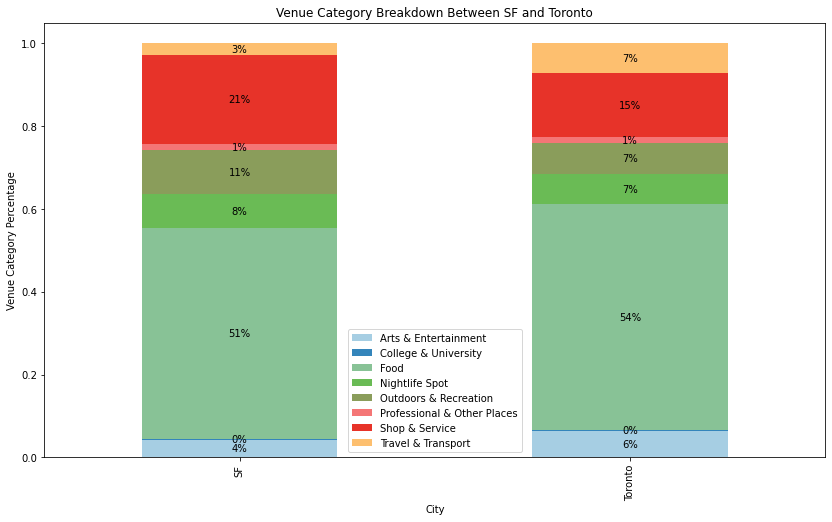

In [27]:
# all_cat_groups_avg.plot.barh(x='City', ax=ax, stacked=True, figsize=(14, 10), colormap=cmap1)
colors = sns.color_palette('Paired', n_colors=all_cat_groups_avg.shape[1]-1)
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)


ax = all_cat_groups_avg.plot.bar(figsize=(14,8), stacked=True, colormap=cmap1)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2,
            y+height/2, 
            '{:.0%}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

    
plt.xlabel('City')
plt.ylabel('Venue Category Percentage')
plt.title('Venue Category Breakdown Between SF and Toronto')
plt.show()

In [28]:
# one hot encoding for venue categories
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
all_onehot.drop(columns=['Neighborhood'], inplace=True)

#add city and neighborhood column back to dataframe
all_onehot.insert(0, 'Neighborhood', all_venues['Neighborhood'])
all_onehot.insert(0, 'City', all_venues['City'])

all_onehot.head()

,City,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Parking,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Sicilian Restaurant,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Sh

In [29]:
all_grouped = all_onehot.groupby(['City','Neighborhood']).mean().reset_index()
all_grouped.head()

,City,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Parking,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Sicilian Restaurant,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Sh

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[['City','Neighborhood']] = all_grouped[['City','Neighborhood']]

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SF,Bayview-Hunters Point,Southern / Soul Food Restaurant,Mexican Restaurant,Café,Bakery,Gym,Liquor Store,Bus Station,BBQ Joint,Chinese Restaurant,Theater
1,SF,Castro/Noe Valley,Gay Bar,Convenience Store,Thai Restaurant,Coffee Shop,Yoga Studio,Indian Restaurant,Cosmetics Shop,Pizza Place,Playground,Plaza
2,SF,Chinatown,Bakery,Coffee Shop,Hotel,Chinese Restaurant,Cocktail Bar,Men's Store,Dim Sum Restaurant,Bubble Tea Shop,Restaurant,Church
3,SF,Haight-Ashbury,Coffee Shop,Park,Bakery,Pizza Place,Thrift / Vintage Store,Scenic Lookout,Supermarket,Bookstore,Smoke Shop,Liquor Store
4,SF,Hayes Valley/Tenderloin/North ...,Café,Hotel,Coffee Shop,French Restaurant,Cocktail Bar,Wine Bar,Mexican Restaurant,Theater,Beer Bar,Sandwich Place


In [32]:
# set number of clusters
kclusters = 7

all_grouped_clustering = all_grouped.drop('City', 1).drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)

# check cluster label generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 3, 3, 3, 0, 0, 0, 3, 3], dtype=int32)

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
all_merged = pd.merge(all_venues.iloc[:,0:4],neighborhoods_venues_sorted, on=['City','Neighborhood']).drop_duplicates().reset_index(drop=True)
all_merged.groupby('Cluster Labels').size()

Cluster Labels
0    13
1     7
2     1
3    33
4     2
5     1
6     1
dtype: int64

In [34]:
all_merged.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SF,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,3,Café,Hotel,Coffee Shop,French Restaurant,Cocktail Bar,Wine Bar,Mexican Restaurant,Theater,Beer Bar,Sandwich Place
1,SF,South of Market,37.772329,-122.41087,3,Nightclub,Food Truck,Gay Bar,Motorcycle Shop,Thai Restaurant,Cocktail Bar,Bar,Clothing Store,Sushi Restaurant,Furniture / Home Store
2,SF,Potrero Hill,37.766529,-122.39577,3,Coffee Shop,Wine Shop,Breakfast Spot,Park,Mexican Restaurant,Café,Deli / Bodega,Distillery,Bubble Tea Shop,Sandwich Place
3,SF,Chinatown,37.792678,-122.40793,3,Bakery,Coffee Shop,Hotel,Chinese Restaurant,Cocktail Bar,Men's Store,Dim Sum Restaurant,Bubble Tea Shop,Restaurant,Church
4,SF,Polk/Russian Hill (Nob Hill),37.792778,-122.42188,3,Grocery Store,Gym / Fitness Center,Deli / Bodega,Italian Restaurant,Wine Bar,Steakhouse,Vietnamese Restaurant,Sushi Restaurant,Bar,Massage Studio


In [35]:
all_merged.groupby(['City','Cluster Labels']).size()

City     Cluster Labels
SF       0                  7
         2                  1
         3                 10
         4                  2
         5                  1
Toronto  0                  6
         1                  7
         3                 23
         6                  1
dtype: int64

In [36]:
all_merged_sf = all_merged.set_index('City').filter(like='SF', axis=0).reset_index(drop=True)
all_merged_sf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hayes Valley/Tenderloin/North ...,37.779329,-122.41915,3,Café,Hotel,Coffee Shop,French Restaurant,Cocktail Bar,Wine Bar,Mexican Restaurant,Theater,Beer Bar,Sandwich Place
1,South of Market,37.772329,-122.41087,3,Nightclub,Food Truck,Gay Bar,Motorcycle Shop,Thai Restaurant,Cocktail Bar,Bar,Clothing Store,Sushi Restaurant,Furniture / Home Store
2,Potrero Hill,37.766529,-122.39577,3,Coffee Shop,Wine Shop,Breakfast Spot,Park,Mexican Restaurant,Café,Deli / Bodega,Distillery,Bubble Tea Shop,Sandwich Place
3,Chinatown,37.792678,-122.40793,3,Bakery,Coffee Shop,Hotel,Chinese Restaurant,Cocktail Bar,Men's Store,Dim Sum Restaurant,Bubble Tea Shop,Restaurant,Church
4,Polk/Russian Hill (Nob Hill),37.792778,-122.42188,3,Grocery Store,Gym / Fitness Center,Deli / Bodega,Italian Restaurant,Wine Bar,Steakhouse,Vietnamese Restaurant,Sushi Restaurant,Bar,Massage Studio


In [37]:
#Import again because of error
import matplotlib.colors as colors

#Define starting location
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters_sf = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_merged_sf['Neighborhood Latitude'], all_merged_sf['Neighborhood Longitude'], all_merged_sf['Neighborhood'], all_merged_sf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster - ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_sf)
       
map_clusters_sf

In [38]:
all_merged_toronto = all_merged.set_index('City').filter(like='Toronto', axis=0).reset_index(drop=True)
all_merged_toronto.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Regent Park,43.654260,-79.360636,3,Coffee Shop,Park,Pub,Café,Bakery,Theater,Breakfast Spot,Yoga Studio,Shoe Store,French Restaurant
1,Harbourfront,43.654260,-79.360636,3,Coffee Shop,Park,Pub,Café,Bakery,Theater,Breakfast Spot,Yoga Studio,Shoe Store,French Restaurant
2,Garden District,43.657162,-79.378937,3,Clothing Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Café,Theater,Fast Food Restaurant,Bookstore,Electronics Store
3,Ryerson,43.657162,-79.378937,3,Clothing Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Café,Theater,Fast Food Restaurant,Bookstore,Electronics Store
4,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,Restaurant,Park,Italian Restaurant,Gastropub,Cosmetics Shop,Pharmacy,Cocktail Bar,Bakery


In [39]:
#Define starting location
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters_toronto = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_merged_toronto['Neighborhood Latitude'], all_merged_toronto['Neighborhood Longitude'], all_merged_toronto['Neighborhood'], all_merged_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster - ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
    
# create map
map_clusters_toronto